# Power Analysis

In [1]:
import cPickle
import datetime
import glob
import gzip
import os
import random
import re
import shutil
import subprocess
import time
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'power_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
exp = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), index_col=0)

rna_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv'),
                         index_col=0)

In [327]:
# Single tissue results.
fns = glob.glob('/publicdata/gtex_20151104/*.eqtl')
gtex_results = {}
for fn in fns:
    gtex_results[os.path.split(fn)[1].split('.')[0]] = pd.read_table(fn, index_col=0,
                                                                     low_memory=False)

I want to look at power a few different ways. 
I want to take my unrelateds and subsample them like GTEx does to see how many
eGenes I gain as I increase my sample size. I should probably run the full eQTL
analysis (with permutations) for the full unrelated set as well.

I'm also going to make an estimate of
my power to detect GTEx and Geuvadis eQTLs and compare them to my actual ability
to detect the eQTLs. For each Geuvadis/GTEx eQTL, I'll calculate an $R^2$. Since 
Geuvadis provides $r$ for each eQTL, I can just square $r$. GTEx provides $\beta$, 
so I can calculate $R^2$ for a given association as 

\begin{align}
R^2 = \left(\beta \frac{s_v}{s_g}\right)^2,
\end{align}

where $s_v$ is the standard deviation of my genotypes at the position and $s_g$ is the
standard deviation of the gene's expression in the GTEx data. I can then calculate

\begin{align}
f^2 = \frac{R^2}{1 - R^2},
\end{align}

which I can use in a power test for linear regression.

The power calculation is kind of slow when done so many times so this notebook takes a while to run
if you need to redo the power calculations.

### Derivation of $R^2$ estimate

For simple linear regression, we know

\begin{align}
\hat{\beta} = \frac{\textrm{cov}(x,y)}{\sigma_x^2},
\end{align}

and

\begin{align}
r = \frac{\textrm{cov}(x,y)}{\sigma_x \sigma_y}.
\end{align}

Thus

\begin{align}
R^2 &= r^2, \\
&= \left(\frac{\hat{\beta}\sigma_x^2}{\sigma_x \sigma_y}\right)^2, \\
&= \left(\hat{\beta}\frac{\sigma_x}{\sigma_y}\right)^2.
\end{align}

## Subsets

In [4]:
cols = [40, 50, 60, 70, 80, 90, 100]
pvals = {}
for i in cols:
    fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                      'unrelated_eqtls_{}'.format(i), 'min_pvalues_corrected.tsv')
    pvals[i] = pd.read_table(fn, index_col=0).min_pval_bf
pvals = pd.DataFrame(pvals)

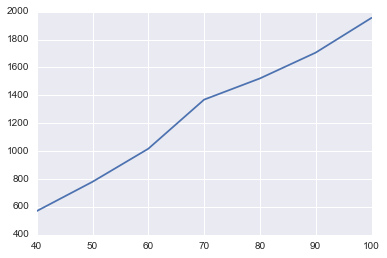

In [5]:
(pvals < 0.05).sum().plot()

## pwr

TODO: Below, I calculate the genotype stdev by pulling the genotypes out of the VCF files.
However, I could more easily just read the EMMAX results files and use the `genocnt` column.
This would save time for this step and the power step since I could avoid calculating power
for some of the GTEx variants I don't have. I also need to make sure to calculate genotype stdev
for each set of subjects (40, 50, 60, etc.).

In [7]:
cluster_setup = False

In [8]:
def pwr_df(df, u, v):
    """
    Execute pwr.f2.test. The dataframe df must have a column f2.
    """
    import rpy2.robjects as ro
    ro.r('suppressPackageStartupMessages(library(pwr))')
    ro.globalenv['df'] = df
    ro.globalenv['u'] = u
    ro.globalenv['v'] = v
    ro.r('p = rep(1, dim(df)[2])')
    ro.r('for(i in 1:dim(df)[1]) {'
         'p[i] = pwr.f2.test(u=u, v=v, f2=df[i, "f2"], '
         'sig.level=0.001, power=NULL)["power"]}')
    p = ro.globalenv['p']
    power = [x[0] for x in p]
    return power

In [305]:
def pwr(f2, u, v):
    """
    Execute pwr.f2.test.
    """
    import rpy2.robjects as ro
    ro.r('suppressPackageStartupMessages(library(pwr))')
    ro.globalenv['f2'] = f2
    ro.globalenv['u'] = u
    ro.globalenv['v'] = v
    ro.r('p = pwr.f2.test(u=u, v=v, f2=f2, sig.level=0.001, power=NULL)["power"]')
    p = list(ro.globalenv['p'])[0][0]
    return p

Here's an example of using `pwr.f2.test`.

In [247]:
%%R

suppressPackageStartupMessages(library(pwr))
pwr.f2.test(u=2, v=117, f2=0.060995, sig.level=0.001, power=NULL)


     Multiple regression power calculation 

              u = 2
              v = 117
             f2 = 0.060995
      sig.level = 0.001
          power = 0.1766086



### Genotype stdev

In [378]:
def calc_stdev(x):
    hr, het, ha = [int(x) for x in x.split('/')]
    out = np.std([0] * hr + [1] * het + [2] * ha)
    return out

In [ ]:
stdev = {}
for i in np.arange(40, 110, 10):
    fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                      'unrelated_eqtls_{}'.format(i), 'top_snv_results_sorted.tsv.gz')
    df = pd.read_table(fn, header=None, low_memory=False)
    se = df[7].apply(lambda x: calc_stdev(x))
    se.index = 'chr' + df[0].astype(str) + ':' + df[1].astype(str)
    stdev['geno_stdev_{}'.format(i)] = se
#stdev = pd.DataFrame(stdev)
#stdev.to_csv(os.path.join(outdir, 'geno_stdev.tsv'), sep='\t')

TODO: refactor below. Code can be simplified now that I have genotype
stdevs calculated ahead of time. I only need to calculate power for
variants I have stdevs for.

### Geuvadis

In [282]:
url = ('ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/'
       'GEUV/E-GEUV-1/analysis_results/EUR373.gene.cis.FDR5.all.rs137.txt.gz')
fn = os.path.join(private_outdir, 'EUR373.gene.cis.FDR5.all.rs137.txt')
if not os.path.exists(fn):
    !curl {url} > {fn + '.gz'}
    !gunzip {fn + '.gz'}

geuvadis_fn = os.path.join(outdir, 'geuvadis_stdev.tsv')
if not os.path.exists(geuvadis_fn):
    geuvadis = pd.read_table(os.path.join(private_outdir, 'EUR373.gene.cis.FDR5.all.rs137.txt'), 
                             low_memory=False)
    # Remove genes that I didn't test.
    geuvadis['ens_gene_id'] = geuvadis.GENE_ID.apply(lambda x: x.split('.')[0])
    tested = pd.DataFrame(True, index=[x.split('.')[0] for x in exp.index], columns=['tested'])
    geuvadis = geuvadis.merge(tested, left_on='ens_gene_id', right_index=True)
    # Remove indels.
    geuvadis = geuvadis[geuvadis.SNPpos - geuvadis.SNPpos.astype(int) == 0]
    snps = geuvadis[['SNP_ID', 'CHR_SNP', 'SNPpos']]
    snps = snps.drop_duplicates()
    snps.CHR_SNP = snps.CHR_SNP.astype(int).astype(str)
    snps.index = snps.CHR_SNP + ':' + snps.SNPpos.astype(int).astype(str)
    # There are a few positions that still have indels. I'll drop any position
    # where there are two entries to fix this.
    vc = pd.Series(snps.index).value_counts()
    vc = vc[vc == 1]
    snps = snps.ix[vc.index]
    
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))

    with dview.sync_imports():
        import numpy
        import vcf

    %px np = numpy
    %px pyvcf = vcf

    dview.push(dict(calc_stdev=calc_stdev))
    dview.push(dict(pwr=pwr))
    
    %px fn = ('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz')
    %px vcf_reader = pyvcf.Reader(open(fn))
    
    cluster_setup = True
    
    stdev = dview.map_sync(lambda x: calc_stdev(x[0], x[1]), snps[['CHR_SNP', 'SNPpos']].values)
    tdf = pd.DataFrame(stdev, columns=['ind', 'genotype_stdev'])
    tdf.index = tdf.ind
    snps = snps.join(tdf)
    geuvadis = geuvadis.merge(snps[['SNP_ID', 'genotype_stdev']])
    geuvadis['r2'] = geuvadis.rvalue ** 2
    geuvadis = geuvadis.dropna(subset=['genotype_stdev'])
    geuvadis['f2'] = geuvadis.r2 / (1 - geuvadis.r2)
    geuvadis.to_csv(geuvadis_fn, sep='\t')
else
    geuvadis = pd.read_table(geuvadis_fn, index_col=0)

Cluster has 9 engines.
importing numpy on engine(s)
importing vcf on engine(s)


In [ ]:
geuvadis_fn = os.path.join(outdir, 'geuvadis_power.tsv')
if not os.path.exists(geuvadis_fn):
    if not cluster_setup:
        from ipyparallel import Client
        parallel_client = Client(profile='parallel')
        dview = parallel_client[:]
        print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
        with dview.sync_imports():
            import numpy
            import vcf

        %px np = numpy
        %px pyvcf = vcf

        dview.push(dict(calc_stdev=calc_stdev))

        %px fn = ('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz')
        %px vcf_reader = pyvcf.Reader(open(fn))
        
        cluster_setup = True

    for n in list(np.arange(40, rna_meta.in_unrelateds.sum(), 10)) + [rna_meta.in_unrelateds.sum()]:
        dview.push(dict(n=n))
        power = dview.map_sync(lambda x: pwr(x, 2, n - 3), geuvadis.f2.values)
        geuvadis['power_{}'.format(n)] = power
            
    # Now I need to read the results for each gene and see whether I tested the
    # particular SNV and what my $p$-value was. One tricky part is that some Gencode
    # IDs are different between the Geuvadis results and my results, but they just 
    # differ by what is after the period. I'll make a mapping.
    geuvadis_genes = pd.DataFrame(geuvadis.GENE_ID.values, 
                                  index=geuvadis.GENE_ID.apply(lambda x: x.split('.')[0]),
                                  columns=['geuvadis']).drop_duplicates()
    my_genes = pd.DataFrame(list(exp.index), 
                            index=[x.split('.')[0] for x in exp.index],
                            columns=['ipsc']).drop_duplicates()
    gene_conv = geuvadis_genes.join(my_genes, how='inner')
    gene_conv['ens'] = gene_conv.index
    gene_conv.index = gene_conv.geuvadis
    
    for i in [40, 50, 60, 70, 80, 90]:
        col = 'sig_{}'.format(i)
        geuvadis[col] = np.nan
        dy = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis',
                          'unrelated_eqtls_{}'.format(i), 'gene_results')
        genes = list(set(geuvadis.GENE_ID))
        for gene in genes:
            fn = os.path.join(dy, gene_conv.ix[gene, 'ipsc'], '{}.tsv'.format(gene_conv.ix[gene, 'ipsc']))
            res = ciepy.read_emmax_output(fn)
            res.index = res.CHROM.astype(str) + ':' + res.BEG.astype(str)
            t = geuvadis[geuvadis.GENE_ID == gene]
            t['ind'] = t.index
            t.index = t.CHR_SNP.astype(str) + ':' + t.SNPpos.astype(int).astype(str)
            t = t.ix[set(res.index) & set(t.index)]
            res = res.ix[t.index]
            geuvadis.ix[t.ind, col] = (res.PVALUE < 0.001).values    
        c = pd.cut(geuvadis['power_{}'.format(i)], np.arange(0, 1.01, 0.01))
        geuvadis['power_{}_bin'.format(i)] = c
    geuvadis.to_csv(geuvadis_fn, sep='\t')

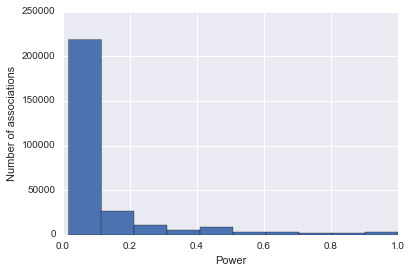

In [311]:
geuvadis.power_40.hist()
plt.xlabel('Power')
plt.ylabel('Number of associations');

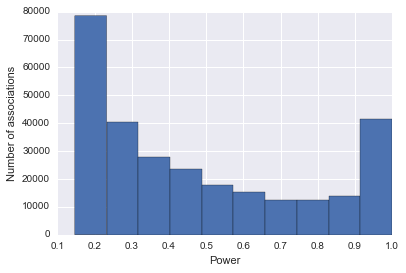

In [313]:
geuvadis.power_118.hist()
plt.xlabel('Power')
plt.ylabel('Number of associations');

In [314]:
def power_plots(tdf):
    for i in np.arange(40, 100, 10):
        df = pd.crosstab(tdf['power_{}_bin'.format(i)], tdf['sig_{}'.format(i)])
        df['percent'] = df[True] / df.sum(axis=1)
        plt.figure()
        df.percent.plot()
        plt.title(i)
        plt.ylabel('Observed power')
        plt.xlabel('Estimated power');

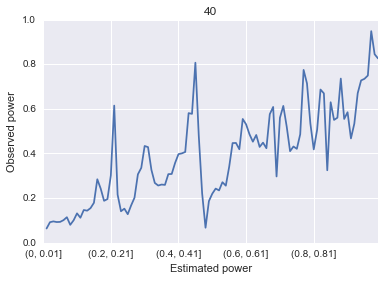

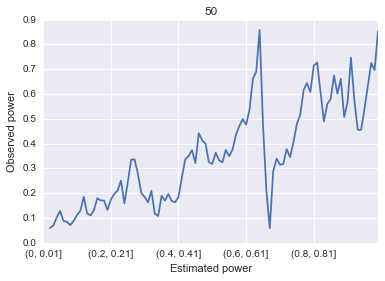

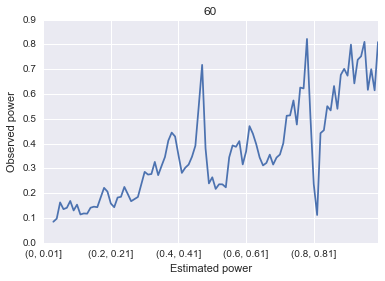

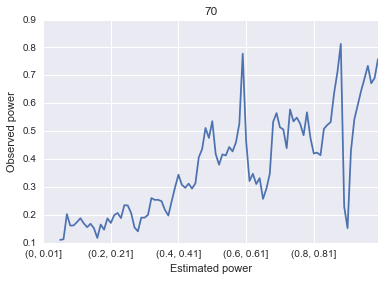

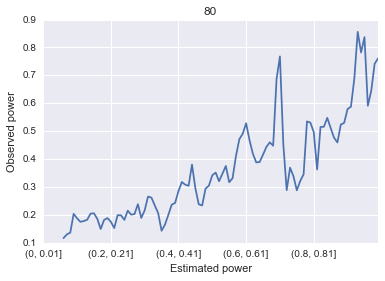

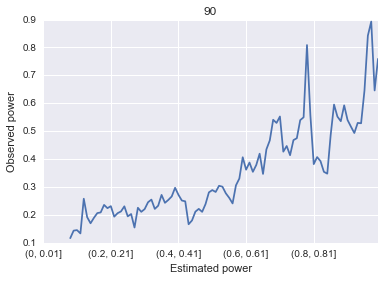

In [315]:
power_plots(geuvadis)

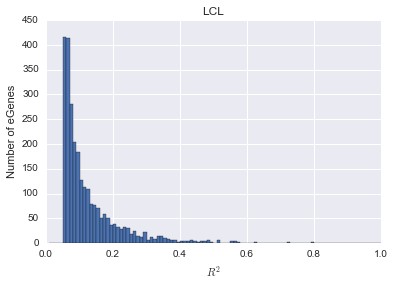

In [357]:
geuvadis.sort_values(by='pvalue').drop_duplicates(subset=['GENE_ID']).r2.hist(bins=np.arange(0, 1.01, 0.01))
plt.title('LCL')
plt.ylabel('Number of eGenes')
plt.xlabel('$R^2$');

### GTEx

In [ ]:
fns = glob.glob(os.path.join(outdir, 'gtex_*_stdev.tsv'))
if len(fns) != len(gtex_results.keys()):
    snps = []
    for k in gtex_results.keys():
        t = gtex_results[k]
        t['indel'] = False
        t.ix[[x[-1] == 'I' or x[-1] == 'D' for x in t.index], 'indel'] = True
        t = t[t.indel == False]
        snps.append(t[['SNP_Chr', 'SNP_Pos']])
        gtex_results[k] = t
    snps = pd.concat(snps)
    snps = snps.drop_duplicates()
    snps.index = (snps.SNP_Chr.astype(str) + ':' + snps.SNP_Pos.astype(str))

    geuvadis_snps = geuvadis[['CHR_SNP', 'SNPpos', 'genotype_stdev']]
    geuvadis_snps.index = (geuvadis_snps.CHR_SNP.astype(str) + ':' + 
                           geuvadis_snps.SNPpos.astype(int).astype(str))
    geuvadis_snps = geuvadis_snps.drop_duplicates()
    
    snps['genotype_stdev'] = np.nan
    ind = list(set(snps.index) & set(geuvadis_snps.index))
    snps.ix[ind, 'genotype_stdev'] = geuvadis_snps.ix[ind, 'genotype_stdev']    
    snps_todo = snps[snps.genotype_stdev.isnull()]

    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    if cluster_setup == False:

        with dview.sync_imports():
            import numpy
            import vcf

        %px np = numpy
        %px pyvcf = vcf

        dview.push(dict(calc_stdev=calc_stdev))

        %px fn = ('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz')
        %px vcf_reader = pyvcf.Reader(open(fn))

        cluster_setup = True

    stdev = dview.map_sync(lambda x: calc_stdev(x[0], x[1]), snps_todo[['SNP_Chr', 'SNP_Pos']].values)
    tdf = pd.DataFrame(stdev, columns=['ind', 'genotype_stdev'])
    tdf.index = tdf.ind
    snps_todo['genotype_stdev'] = tdf.ix[snps_todo.index, 'genotype_stdev']
    snps.ix[snps_todo.index, 'genotype_stdev'] = snps_todo.genotype_stdev
    snps = snps[snps.genotype_stdev.isnull() == False]
    
    for k in gtex_results.keys():
        t = gtex_results[k]
        t.location = t.SNP_Chr.astype(str) + ':' + t.SNP_Pos.astype(str)
        t['genotype_stdev'] = snps.ix[t.location, 'genotype_stdev'].values
        t = t.dropna(subset=['genotype_stdev'])
        t['r2'] = (t.Beta * t.genotype_stdev)**2
        t['f2'] = t.r2 / (1 - t.r2)
        gtex_results[k] = t
        df.to_csv(os.path.join(outdir, 'gtex_{}_stdev.tsv'.format(k)), sep='\t')
# TODO: read in gtex results if this step doesn't run

In [360]:
len(gtex_results)

13

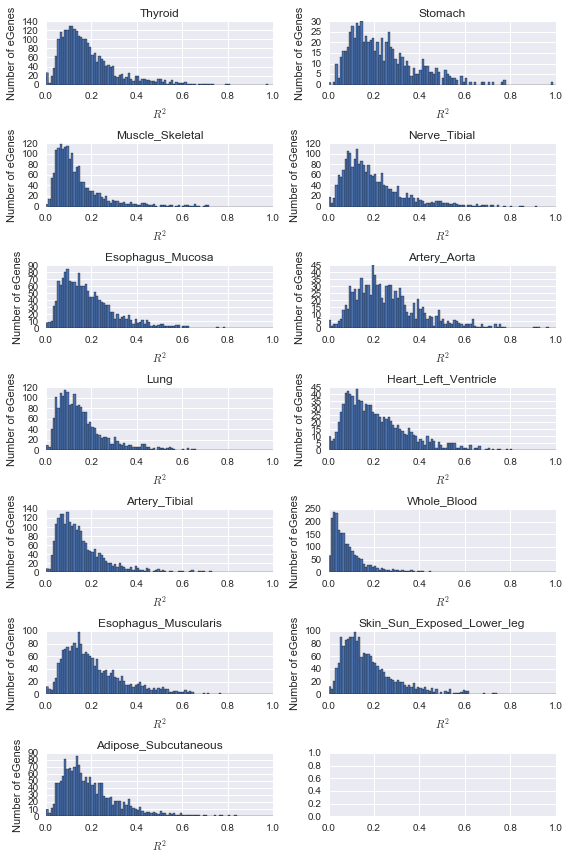

In [371]:
fig,axs = plt.subplots(7, 2, figsize=(8, 12))
for i,k in enumerate(gtex_results.keys()):
    ax = axs[i / 2, i % 2]
    t = gtex_results[k]
    t = t.sort_values(by='P_Val')
    t = t.drop_duplicates('Gen_ID')
    t.r2.hist(bins=np.arange(0, 1.01, 0.01), ax=ax)
    ax.set_title(k);
    ax.set_ylabel('Number of eGenes')
    ax.set_xlabel('$R^2$');
plt.tight_layout()

In [319]:
fns = glob.glob(os.path.join(outdir, 'gtex_*_power.tsv'))
if len(fns) != len(gtex_results.keys()):
    for k in gtex_results.keys():
        df = gtex_results[k]
        df = df[df.f2 > 0]
        for n in list(np.arange(40, rna_meta.in_unrelateds.sum(), 10)) + [rna_meta.in_unrelateds.sum()]:
            dview.push(dict(n=n))
            power = dview.map_sync(lambda x: pwr(x, 2, n - 3), df.f2.values)
            df['power_{}'.format(n)] = power
        gtex_results[k] = df
        
        
    gtex_genes = set()
    for t in gtex_results.values():
        gtex_genes |= set(t.Gen_ID)

    gtex_genes = list(gtex_genes)
    gtex_genes = pd.DataFrame(gtex_genes, 
                              index=[x.split('.')[0] for x in gtex_genes],
                              columns=['gtex']).drop_duplicates()
    my_genes = pd.DataFrame(list(exp.index), 
                            index=[x.split('.')[0] for x in exp.index],
                            columns=['ipsc']).drop_duplicates()
    gtex_gene_conv = gtex_genes.join(my_genes, how='inner')
    gtex_gene_conv['ens'] = gtex_gene_conv.index
    gtex_gene_conv.index = gtex_gene_conv.gtex

    gtex_sig = []
    for t in gtex_results.values():
        tt = t.SNP_Chr.astype(str) + ':' + t.SNP_Pos.astype(str) + ':' + t.Gen_ID
        tt.index = t.Gen_ID
        gtex_sig.append(tt)
    gtex_sig = pd.concat(gtex_sig).drop_duplicates()
    gtex_sig = gtex_sig.ix[gtex_gene_conv.index].dropna()

    my_gtex_results = pd.DataFrame(index=gtex_sig.values)

    for i in [40, 50, 60, 70, 80, 90]:
        col = 'sig_{}'.format(i)
        my_gtex_results[col] = np.nan
        dy = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis',
                          'unrelated_eqtls_{}'.format(i), 'gene_results')
        for gene in set(gtex_sig.index):
            fn = os.path.join(dy, gtex_gene_conv.ix[gene, 'ipsc'], '{}.tsv'.format(gtex_gene_conv.ix[gene, 'ipsc']))
            res = ciepy.read_emmax_output(fn)
            res.index = res.CHROM.astype(str) + ':' + res.BEG.astype(str) + ':' + gene
            t = gtex_sig.ix[gene]
            if type(t) == str:
                ind = [t]
            else:
                ind = t.values
            ind = set(res.index) & set(ind)
            res = res.ix[ind]
            my_gtex_results.ix[ind, col] = (res.PVALUE < 0.001).values

    for k in gtex_results.keys():
        tdf = gtex_results[k]
        for i in np.arange(40, 100, 10):
            tdf['power_{}_bin'.format(i)] = pd.cut(tdf['power_{}'.format(i)], np.arange(0, 1.01, 0.01)).values
        tdf['chr_pos_gene_id'] = tdf.SNP_Chr.astype(str) + ':' + tdf.SNP_Pos.astype(str) + ':' + tdf.Gen_ID
        tdf = tdf.merge(my_gtex_results, left_on='chr_pos_gene_id', right_index=True).dropna(subset=['sig_40'])
        gtex_results[k] = tdf
        tdf.to_csv(os.path.join(outdir, 'gtex_{}_sig.tsv'.format(k)))

KeyError: ['sig_40']

In [323]:
my_gtex_results.head()

,sig_40,sig_50,sig_60,sig_70,sig_80,sig_90
6:41059169:ENSG00000001167.10,False,False,False,False,False,False
6:41059458:ENSG00000001167.10,False,False,False,False,False,False
6:41060212:ENSG00000001167.10,False,False,False,False,False,False
6:41082590:ENSG00000001167.10,False,False,False,False,False,False
6:41095817:ENSG00000001167.10,False,False,False,False,False,False


In [324]:
gtex_results.keys()

['Thyroid',
 'Stomach',
 'Muscle_Skeletal',
 'Nerve_Tibial',
 'Esophagus_Mucosa',
 'Artery_Aorta',
 'Lung',
 'Heart_Left_Ventricle',
 'Artery_Tibial',
 'Whole_Blood',
 'Esophagus_Muscularis',
 'Skin_Sun_Exposed_Lower_leg',
 'Adipose_Subcutaneous']

In [325]:
gtex_results['Stomach'].head()

,SNP_Chr,SNP_Pos,Gen_ID,Gene_Name,Gene_Pos,T_Stat,Beta,P_Val,min(p),EmpP,...,power_70_bin,power_80_bin,power_90_bin,chr_pos_gene_id,sig_40,sig_50,sig_60,sig_70,sig_80,sig_90
SNP,,,,,,,,,,,,,,,,,,,,,
rs10049087,3,50123417,ENSG00000004534.10,RBM6,49977440,6.032298,0.549695,1.513607e-07,7.033544e-11,0.0001,...,"(0.42, 0.43]","(0.52, 0.53]","(0.61, 0.62]",3:50123417:ENSG00000004534.10,False,True,False,True,False,False
rs1046953,3,50197097,ENSG00000004534.10,RBM6,49977440,5.425615,0.489685,1.395149e-06,7.033544e-11,0.0001,...,"(0.24, 0.25]","(0.31, 0.32]","(0.38, 0.39]",3:50197097:ENSG00000004534.10,False,False,False,False,False,False
rs1062633,3,49924940,ENSG00000004534.10,RBM6,49977440,-6.459712,-0.588009,3.098141e-08,7.033544e-11,0.0001,...,"(0.55, 0.56]","(0.65, 0.66]","(0.74, 0.75]",3:49924940:ENSG00000004534.10,False,True,False,True,False,False
rs11130224,3,49936910,ENSG00000004534.10,RBM6,49977440,-6.934510,-0.591471,5.263309e-09,7.033544e-11,0.0001,...,"(0.53, 0.54]","(0.64, 0.65]","(0.73, 0.74]",3:49936910:ENSG00000004534.10,False,True,False,True,False,False
rs11130226,3,49993191,ENSG00000004534.10,RBM6,49977440,-7.199342,-0.602009,1.954945e-09,7.033544e-11,0.0001,...,"(0.58, 0.59]","(0.69, 0.7]","(0.77, 0.78]",3:49993191:ENSG00000004534.10,False,True,False,True,False,False


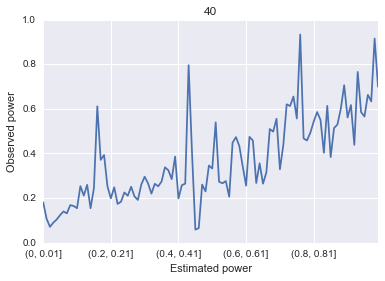

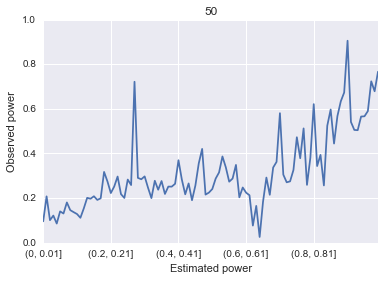

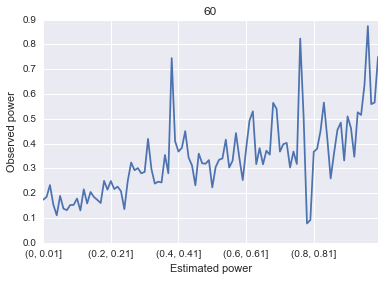

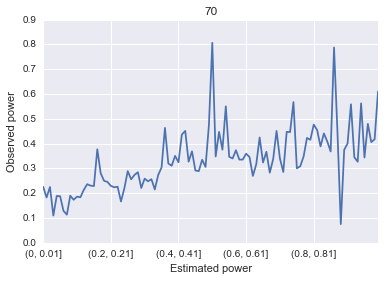

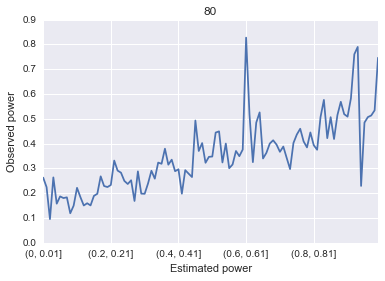

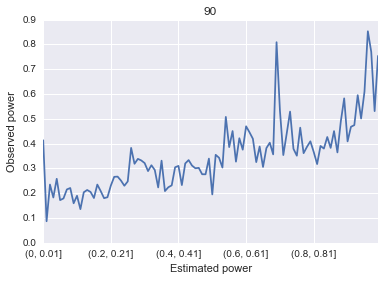

In [326]:
power_plots(gtex_results['Thyroid'])

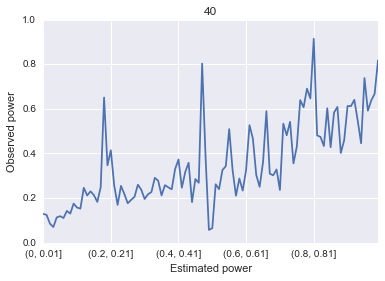

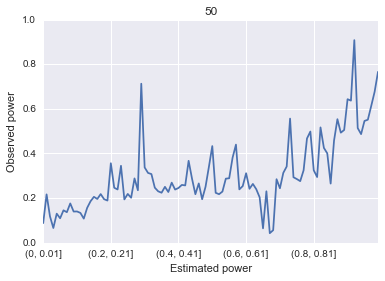

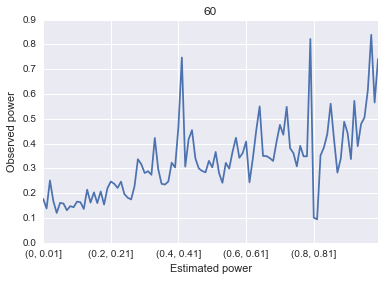

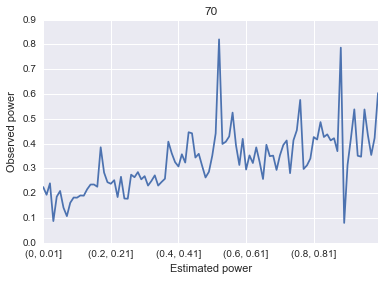

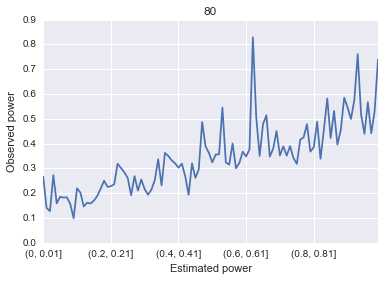

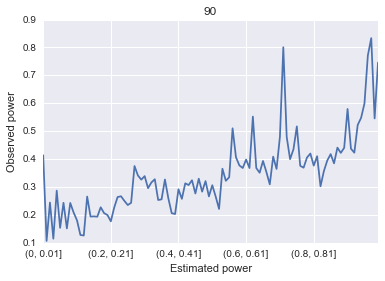

In [240]:
power_plots(gtex_results['Thyroid'])